In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from typing import List, Union, Optional, Callable
import pickle
from Bio import AlignIO, SeqIO
from ete3 import Tree, TreeNode
from gctree import CollapsedTree

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from ete3 import Tree, faces, TreeStyle, NodeStyle, TextFace, SequenceFace, COLOR_SCHEMES, CircleFace
from GCTree_preparation import *
import warnings
import math
warnings.filterwarnings("ignore")

path_to_storage = "/media/hieunguyen/HNSD01/storage/all_BSimons_datasets"
outdir = "/media/hieunguyen/HNSD_mini/outdir/sc_bulk_BCR_data_analysis_v0.1"

PROJECT = "220701_etc_biopsies"
path_to_main_output = f"{outdir}/tree_analysis/{PROJECT}"
path_to_01_output = os.path.join(path_to_main_output, "01_output")
os.system(f"mkdir -p {path_to_01_output}")

output_type = "mouse_based_output"

path_to_trees = os.path.join(path_to_storage, PROJECT, "GCtrees/v0.2", output_type)

all_tree_folder = [item for item in pathlib.Path(path_to_trees).glob("*") if 
                   os.path.isfile(f"{str(item)}/02_dnapars/gctree.out.inference.1.nk") == True]

all_nk_files = [item for item in pathlib.Path(path_to_trees).glob("*/*/*gctree.out.inference.1.nk")]  
print(f"Number of trees: {len(all_tree_folder)}")   

path_to_metadata = "/media/hieunguyen/HNSD01/src/sc_bulk_BCR_data_analysis/preprocessing/220701_etc_biopsies/metadata.csv"
mid_metadata = pd.read_csv(path_to_metadata, sep =";")

##### Re run the summary analysis of all trees and rendering tree figures
# rerun = True
rerun = False

path_to_04_output = os.path.join(outdir, "VDJ_output", "04_output")
thres = 0.85

clonedf = pd.read_csv(os.path.join(path_to_04_output, "full_clonedf_with_mutation_rate.csv"), index_col= [0])
clonedf = clonedf[clonedf['num_mutation'] != "region_not_covered-skip"]
clonedf = clonedf[clonedf['dataset.name'] == "220701_etc_biopsies"]

maindf = pd.read_csv(f"{path_to_01_output}/tree_summarydf.csv")
    # Reload the dictionary from the pickle file
with open(f"{path_to_01_output}/saveTreeobj.pkl", "rb") as f:
    saveTreeobj = pickle.load(f)

color_path = "./hex_color.csv"

/home/hieunguyen/miniconda3/envs/ete3_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of trees: 7618


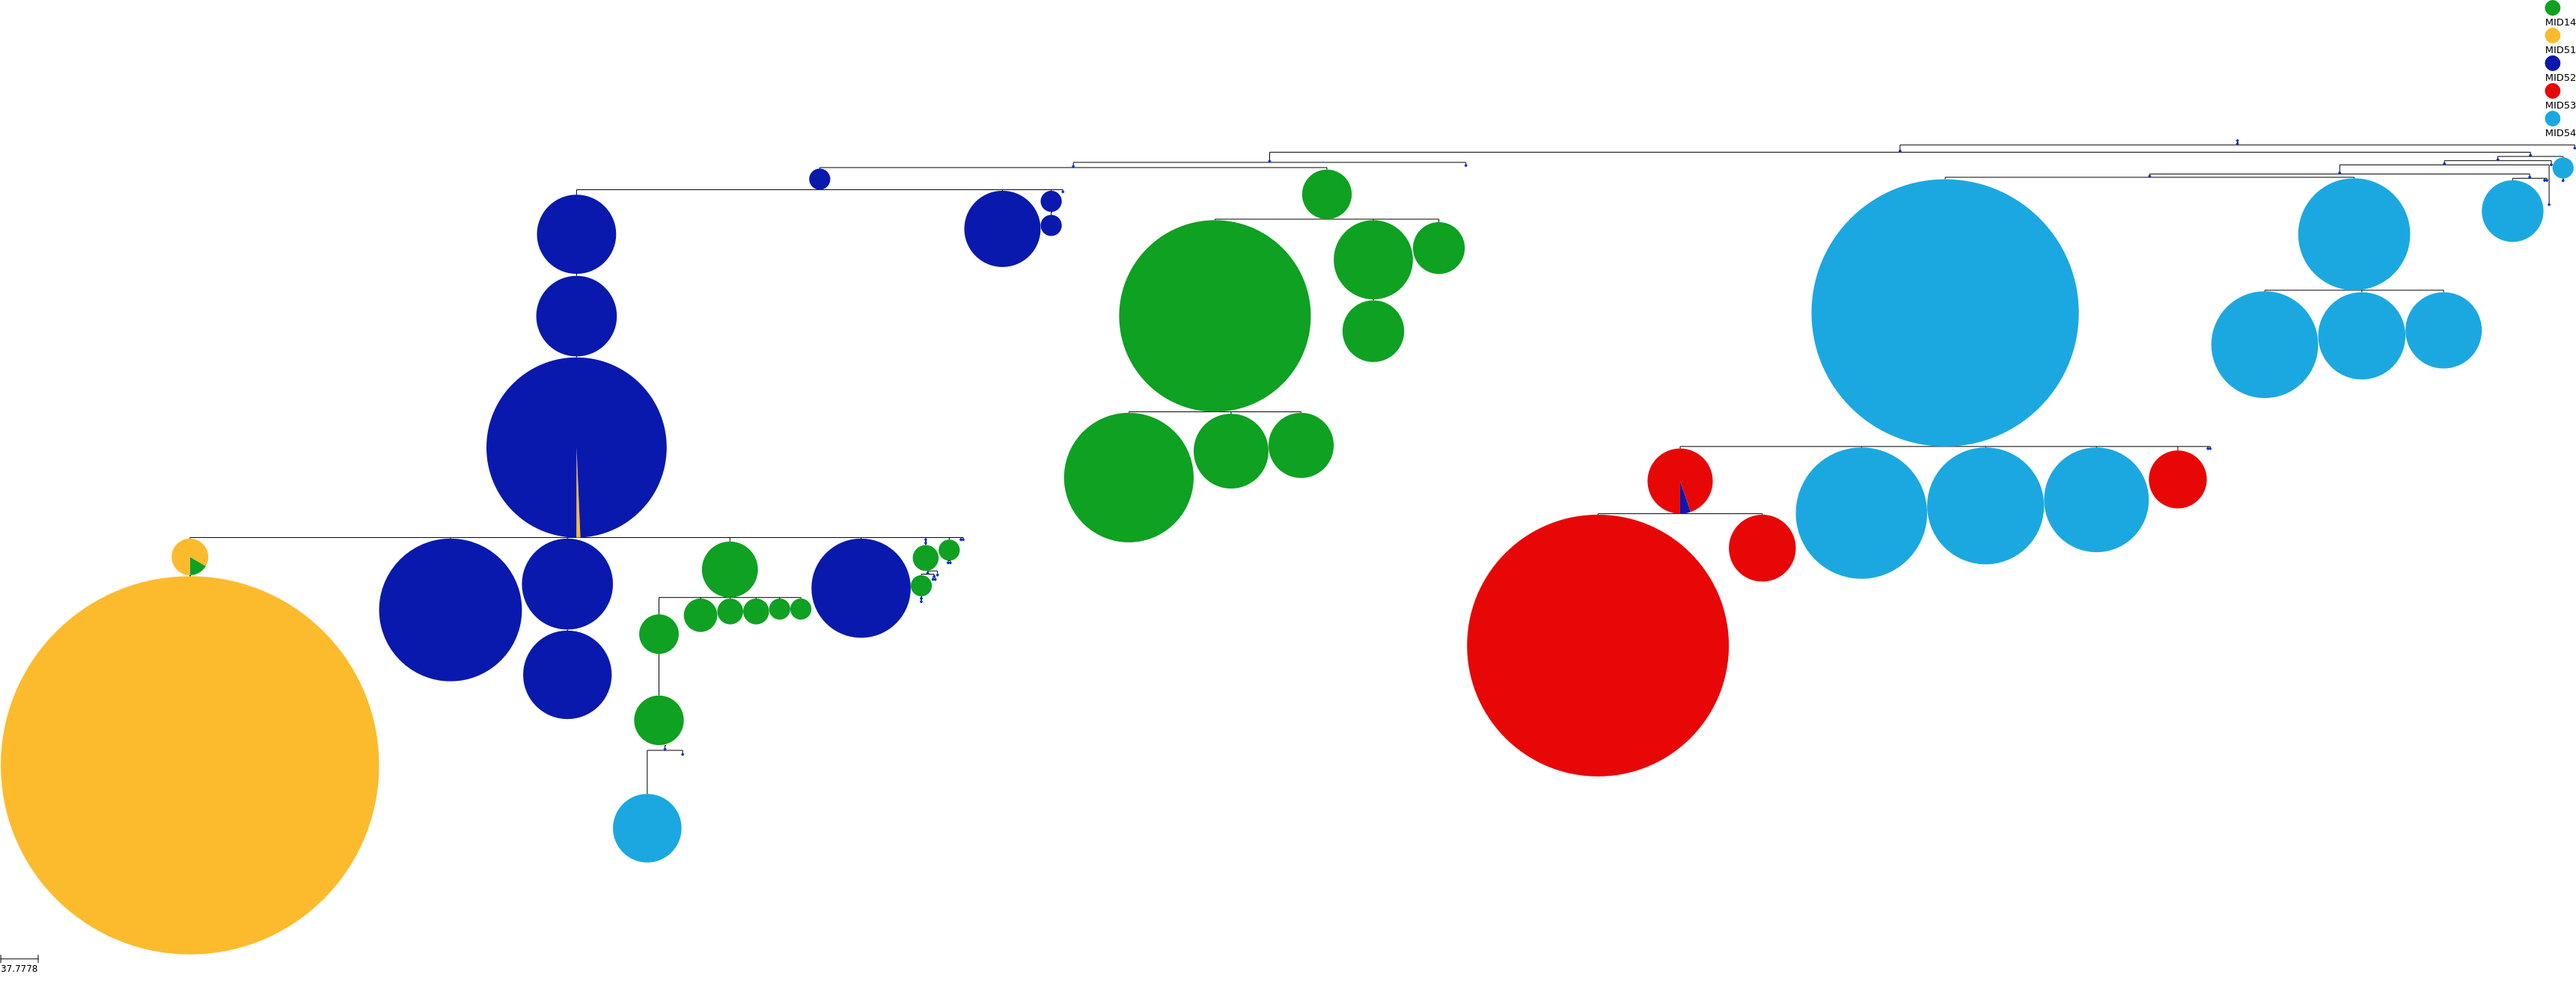

In [2]:
##### analysis example for 1 tree. 
cloneid = "m30_IGHV1-82-01_IGHJ2-01_30_1.aln"

mouseid = cloneid.split("_")[0]
path_to_save_tree_svg = os.path.join(path_to_01_output, mouseid)
os.system(f"mkdir -p {path_to_save_tree_svg}")

treeobj = saveTreeobj[cloneid] 
avai_mids = treeobj.seqdf["MID"].unique()
mid_color_pal = pd.read_csv(color_path, index_col = [0]).to_dict()["hex color"]

ts = treeobj.generate_tree_style(color_path = color_path)
# treeobj.tree.render("%%inline", tree_style=ts) 

for input_mid in avai_mids:
    if input_mid == "GL":
        input_mid_col = "gray"
    else:
        input_mid_col = mid_color_pal[input_mid]
    ts.legend.add_face(CircleFace(10, input_mid_col), column = 0)
    ts.legend.add_face(TextFace(input_mid), column = 0)

idmapdf = treeobj.idmapseqdf.copy()
seqdf = treeobj.seqdf.copy()
seqdf["population"] = seqdf["MID"].apply(lambda x: mid_metadata[mid_metadata["Unnamed: 0"] == x]["population"].values[0])
seqdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")
treeobj.tree.render(f"%%inline", tree_style=ts) 


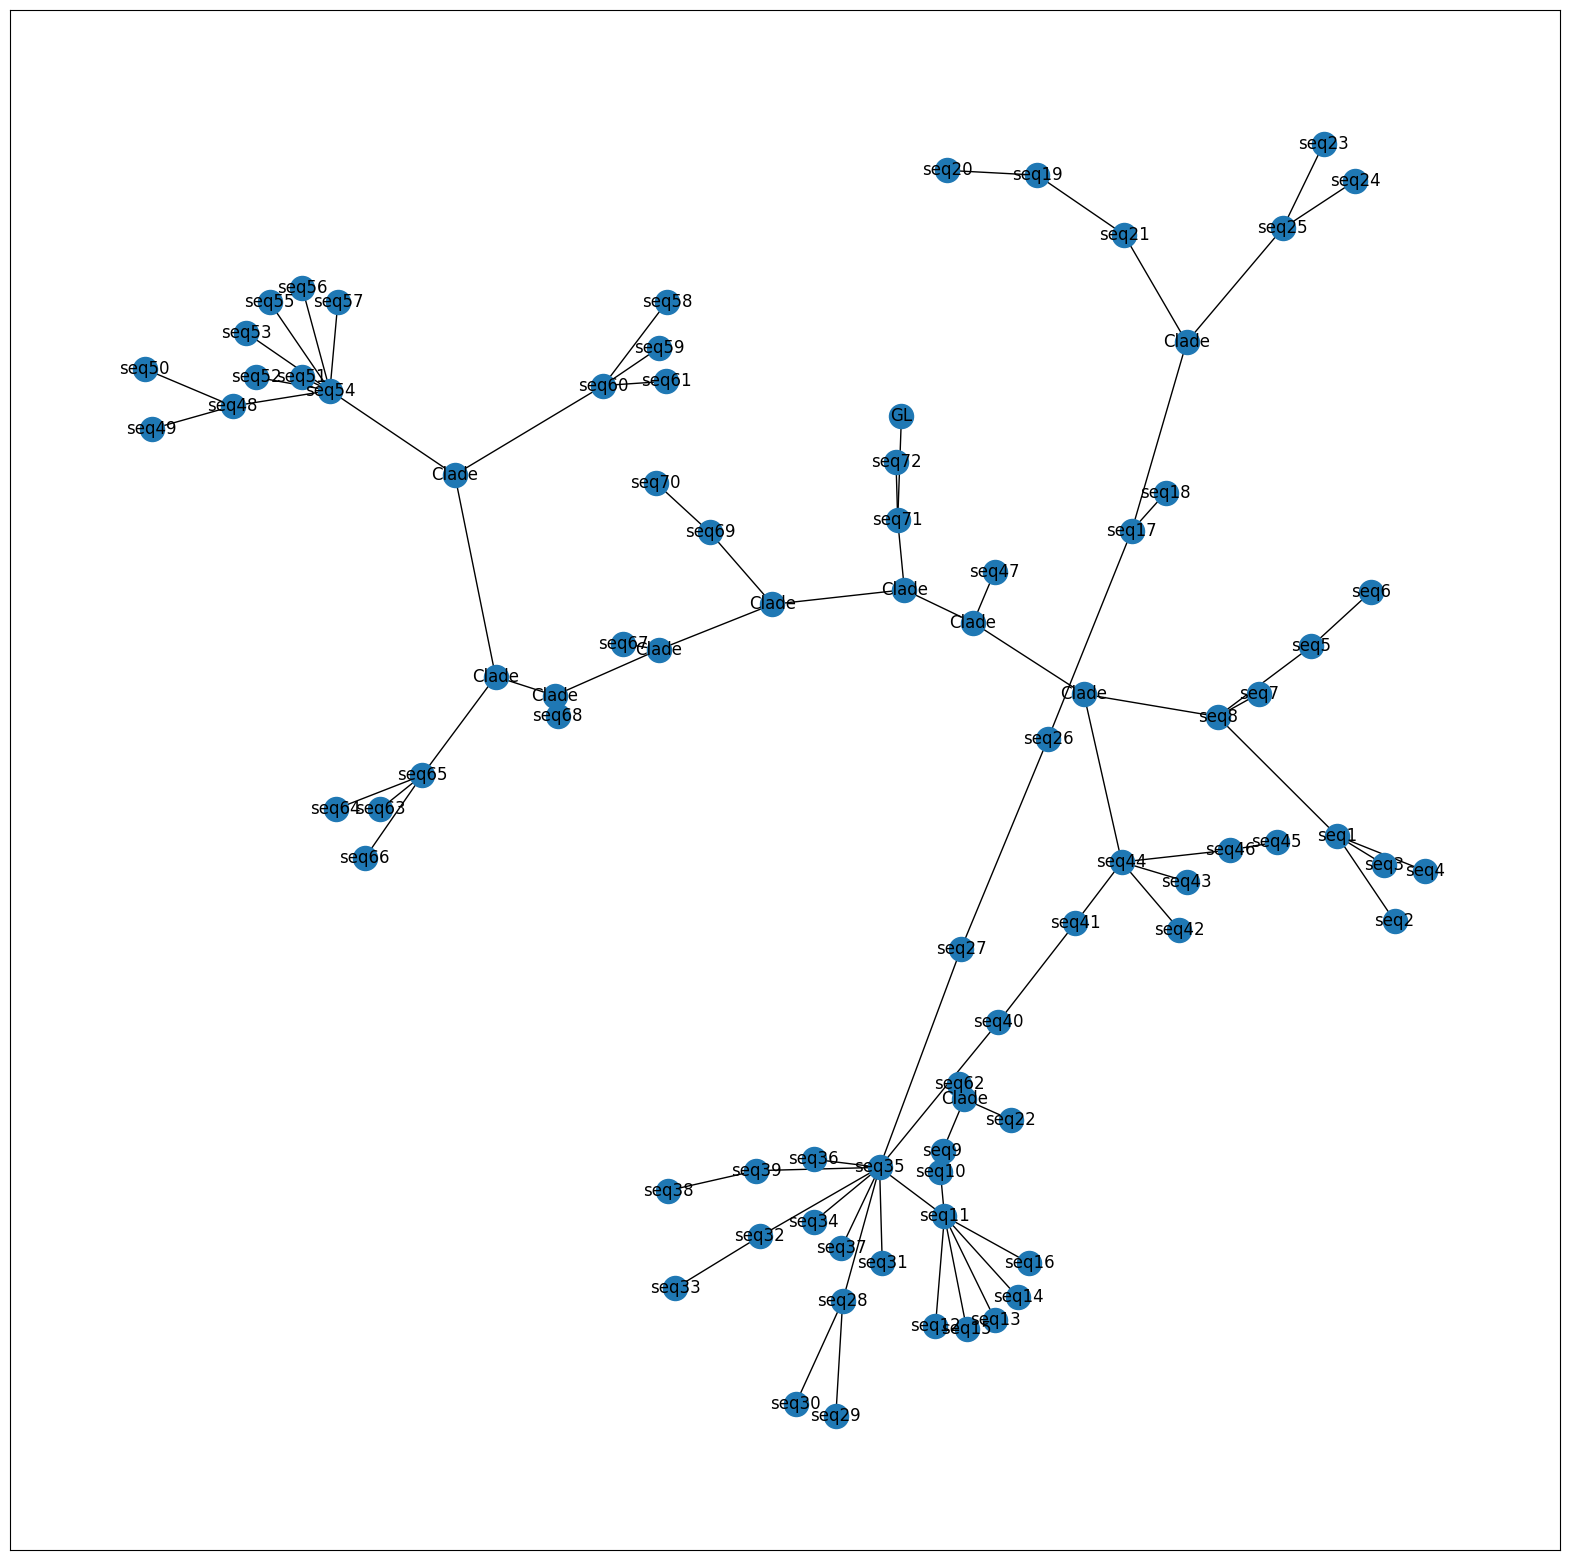

In [73]:
nw_path = os.path.join("/media/hieunguyen/HNSD01/storage/all_BSimons_datasets/220701_etc_biopsies/GCtrees/v0.2/mouse_based_output/m30_IGHV1-82-01_IGHJ2-01_30_1.aln/02_dnapars",
                       "gctree.out.inference.1.nk"
                       )

Tree = Phylo.read(nw_path, 'newick')
plt.figure(figsize=(20, 20))
G = Phylo.to_networkx(Tree)
pos = nx.spring_layout(G, seed = 42)  # Define the layout for the nodes
nx.draw_networkx(G, pos=pos)
plt.show()


In [74]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def test():
    # to install networkx 2.0 compatible version of python-louvain use:
    # pip install -U git+https://github.com/taynaud/python-louvain.git@networkx2
    from community import community_louvain

    g = nx.karate_club_graph()
    partition = community_louvain.best_partition(g)
    pos = community_layout(g, partition)

    nx.draw(g, pos, node_color=list(partition.values())); plt.show()
    return

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# installation easiest via pip:
# pip install netgraph
from netgraph import Graph

# create a modular graph
partition_sizes = [10, 20, 30, 40]
g = nx.random_partition_graph(partition_sizes, 0.5, 0.1)

# since we created the graph, we know the best partition:
node_to_community = dict()
node = 0
for community_id, size in enumerate(partition_sizes):
    for _ in range(size):
        node_to_community[node] = community_id
        node += 1

# # alternatively, we can infer the best partition using Louvain:
# from community import community_louvain
# node_to_community = community_louvain.best_partition(g)

community_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
}
node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

Graph(g,
      node_color=node_color, node_edge_width=0, edge_alpha=0.1,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled', edge_layout_kwargs=dict(k=2000),
)

plt.show()